# MNIST Dataset

M-LIME explanations for a Convolutional Neural Networking (CNN) model. The model was trained using the MNIST Dataset.

In [1]:
import os, sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from m_lime.generators.vae_gen import VAEGen
from m_lime.explainers.explainer import Explainer
from m_lime.explainers.visualizations.visualization import ImagePlot

import torch
import torch.utils.data
from torchvision import datasets, transforms
import mnist_CNN

# Loadind data

In [2]:
epochs = 10
cuda = torch.cuda.is_available()
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
device = torch.device("cuda" if cuda else "cpu")
device_cpu = torch.device("cpu")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

### ML Model - CNN using Torch

In [3]:
path='model_mnist_cnn.pth'
model = mnist_CNN.model_load(device, path=path)
def model_predict(x_):
    if isinstance(x_, torch.Tensor):
        x_tf = x_
    else:
        x_tf = torch.from_numpy(x_)
    with torch.no_grad():
        x_tf = x_tf.reshape(-1, 1, 28, 28)
        y = model(x_tf.to(device=device))
        y = y.data.exp().to(device_cpu).numpy()
        return y

### M-LIME using KDEGen

In [4]:
generator = VAEGen(input_dim=784)
# density.fit(train_loader, epochs=40)
# density.save_manifold('./model_vae_manifold.pth')
generator = generator.load_manifold('./model_vae_manifold.pth')

In [5]:
def get_explanation(x_explain, model_predict, class_to_explain, local_class, r):
    print("Explanation for: ", class_to_explain)
    print("Probability:", model_predict(x_explain)[0][class_to_explain])
    explain_linear = Explainer(
        model_predict=model_predict,
        generator=generator,
        local_model=local_class
    )
    explanation, contra = explain_linear.explain_instance(
        x_explain=x_explain,
        r=r,
        n_samples=1000,
        class_index=class_to_explain,
        tol_importance=0.01,
        tol_error=0.01,
        weight_kernel=None,
        local_mini_batch_max=100,
        scale_data=False
    )
    return explanation, contra
   
def explain(x_explain, model_predict, class_to_explain, local_class, r):
    explanation, contra = get_explanation(
        x_explain, model_predict, class_to_explain, local_class, r)
    fig, axis = ImagePlot.plot_importance_contrafactual(explanation.explain(), contra, class_to_explain)
    plt.savefig(
        f'MNIST_e_c_{class_to_explain}.png', dpi=300, interpolation='none')
    return explanation

In [6]:
local_class = 'SGD'
r = 0.9
explain_linear = None
torch.cuda.empty_cache()

### Explain a instance

In [7]:
x_explain = np.loadtxt('five_example_1.np').astype(np.float32).reshape(1, 28, 28)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)
print('Predicted:', y_explain_index, y_explain[0][y_explain_index])
top_three = np.argsort(y_explain)[0][::-1]
print('Top 3 predicted Class', top_three[:3])
y = f'Prediction: {np.argmax(y_explain):}'

Predicted: 5 0.44421804
Top 3 predicted Class [5 6 8]


## Explaining a number 5

Explanation for:  5
Probability: 0.44421804


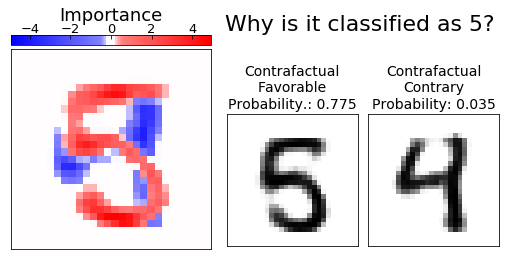

In [8]:
explanation = explain(
    x_explain, model_predict, top_three[0], local_class=local_class, r=r)

Explanation for:  6
Probability: 0.16739056


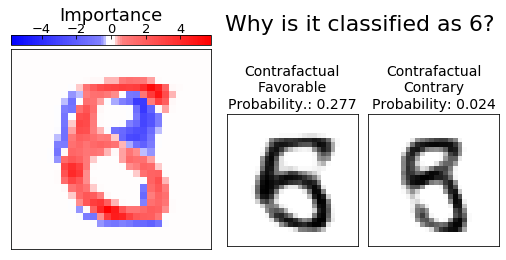

In [9]:
explanation = explain(x_explain, model_predict, top_three[1], local_class, r)

Explanation for:  8
Probability: 0.15582435


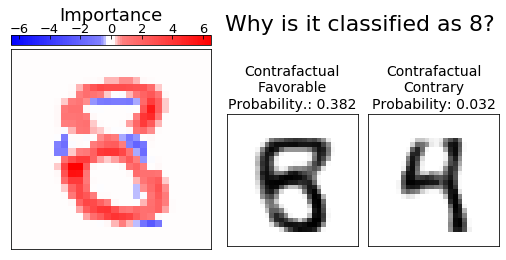

In [10]:
explanation = explain(x_explain, model_predict, top_three[2], local_class, r)

Explanation for:  9
Probability: 0.08754067


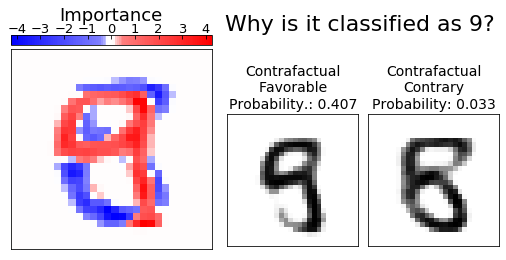

In [11]:
explanation = explain(x_explain, model_predict, top_three[3], local_class, r)

# Explaining another number 5

In [13]:
x_explain = np.loadtxt('five_example_2.np').astype(np.float32).reshape(1, 28, 28)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)
print('predicted:', y_explain_index, y_explain[0][y_explain_index])
top_three = np.argsort(y_explain)[0][::-1]
print('top 3 predicted Class', top_three[:3])
y = f'Prediction: {np.argmax(y_explain)}'

predicted: 5 0.52969086
top 3 predicted Class [5 3 9]


Explanation for:  5
Probability: 0.52969086


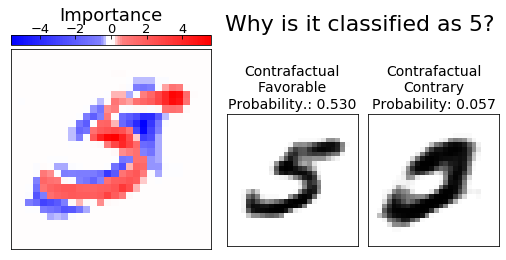

In [14]:
explanation = explain(x_explain, model_predict, top_three[0], local_class, r)

Explanation for:  3
Probability: 0.21647812


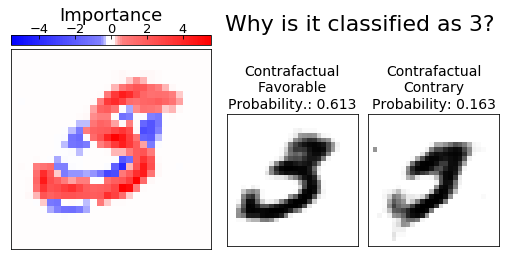

In [15]:
explanation = explain(x_explain, model_predict, top_three[1], local_class, r)

Explanation for:  9
Probability: 0.08599733


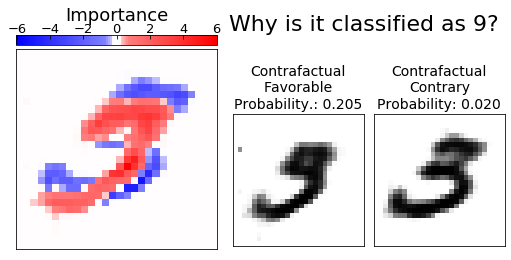

In [16]:
explanation = explain(x_explain, model_predict, top_three[2], local_class, r)

# Explaining a number 3

In [17]:
x_explain = np.loadtxt('three_example.np').astype(np.float32).reshape(1, 28, 28)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)
print('predicted:', y_explain_index, y_explain[0][y_explain_index])
top_three = np.argsort(y_explain)[0][::-1]
print('top 3 predicted Class', top_three[:3])
y = f'Prediction: {np.argmax(y_explain):}'

predicted: 3 0.31112874
top 3 predicted Class [3 9 5]


Explanation for:  3
Probability: 0.31112874


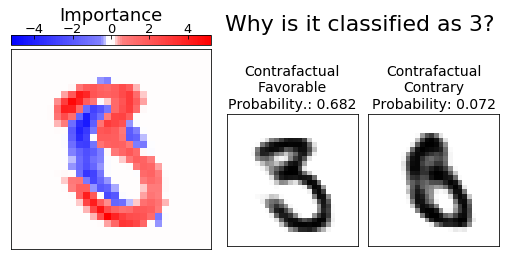

In [18]:
explanation = explain(x_explain, model_predict, top_three[0], local_class, r)

Explanation for:  9
Probability: 0.18863097


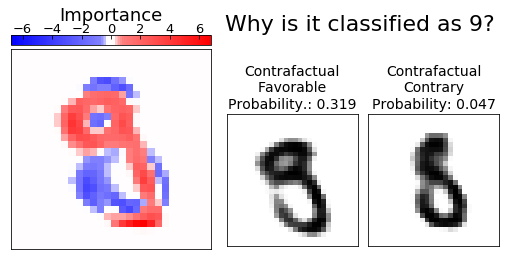

In [19]:
explanation = explain(x_explain, model_predict, top_three[1], local_class, r)

Explanation for:  5
Probability: 0.13742018


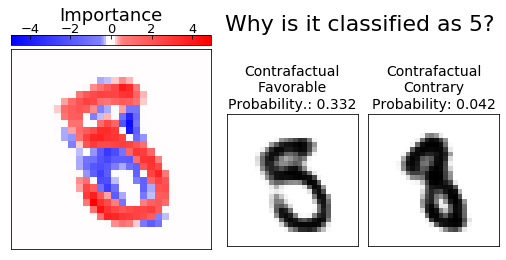

In [20]:
explanation = explain(x_explain, model_predict, top_three[2], local_class, r)

Explanation for:  8
Probability: 0.09787022


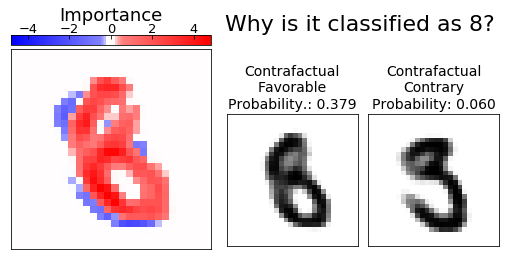

In [21]:
explanation = explain(x_explain, model_predict, top_three[3], local_class, r)

Thank you!